### FRB Event Rate

Calculate the expected FRB event rate for thew ALFABURST survey based on Lorimer et al. 2013

**Assumptions**

1. Pulse width is approximately 1 ms
2. FRB is a standard candles
3. Thornton et al. 2013 correctly relates flux density to redshift

In [264]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from matplotlib import rc

%matplotlib inline
rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (12, 8)

Equation 6 of Karastergiou et al. 2015 is derived from the radiometer equation:

$$
S_{min} = \textrm{SEFD} \frac{\textrm{SNR}_{min}}{\sqrt{D \; \tau \; \Delta \nu}}
$$

where $S_{min}$ is the minimum flux density (in Jy) detection rate. This is based on the telescope SEFD, the minimum SNR detection level $\textrm{SNR}_{min}$ and the decimation rate $D$ compared to the native instrumental time resolution $\tau$, this comes from the search pipeline which averages together spectra to search for scattered pulses. ALFABURST has a native resolution of $256 \; \mu s$, effective bandwidth $\Delta \nu = 56 \textrm{MHz}$, and $\textrm{SNR}_{min} = 10$.

For reference see:
* https://www.cv.nrao.edu/course/astr534/Radiometers.html
* http://www.naic.edu/alfa/performance/
* https://casper.berkeley.edu/astrobaki/index.php/Radiometer_Equation_Applied_to_Telescopes
* https://science.nrao.edu/facilities/vla/docs/manuals/oss/performance/sensitivity

In [283]:
# Parameters
SEFD = 3. # Jy, SEFD of ALFA (main beam)
threshold = 10. # SNR threshold of detection pipeline
pulseWidth = np.array([1., 2., 4., 8., 16., 32., 64.]) * 1000. # us, expected pulse width
tRes = 256. # us, ALFABURST spectra time resolution
dFactor = pulseWidth / tRes# decimation factor
bw = 56. * 1e6 # ALFABURST effective bandwidth in Hz
sMin = SEFD * (threshold / np.sqrt(dFactor * (tRes * 1e-6) * bw)) # Minimum flux density detection, based on radiometer equation

fObsMin = 1347e6 # ALFABURST 56 MHz bandwidth system min frequency
fObsMax = 1403e6 # ALFABURST 56 MHz bandwidth system max frequency

alphas = [-2., -1.4, -0.7, -0.1, 0.1, 0.7] # spectral indicies to model
zMin = 0.01
zMax = 4.0
#zMax = 8.234 # from frb_search_volume.ipynb

In [280]:
def coMovingDist(z):
    """Co-moving distance in Gpc, Eq. 3 from Lorimer et al. 2013
    z: float, redshift
    """
    c = 299792.458 # km s^-1
    H0 = 68. # km s^-1 Mpc^-1
    OmegaM = 0.32
    OmegaLambda = 0.68
    
    integrand = lambda zp: 1. / np.sqrt(OmegaM * ((1. + zp)**3.) + OmegaLambda)
    dd, err = scipy.integrate.quad(integrand, 0., z)
    return ((c/H0) * dd) * 1e-3

def coMovingVol(z):
    """Co-moving volume in Gpc^3
    z: float, redshift"""
    return (4./3.)*(coMovingDist(z)**3.)

def calcLModel(sPeakRef=1., alphaRef=-1.4, zRef=0.75, fLumMin=1e7, fLumMax=1e10, fObsMin=1182e6, fObsMax=1582e6):
    """Calculate the standard candle FRB bolometric luminosity based on Thornton et al. 2013 model, this is used
    to calibrate the flux-redshift relationship
    sPeakRef: float, Jy, peak flux density, Thornton et al.: 1.
    alphaRef: float, spectal index, Thornton et al.: -1.4
    zRef: float, redshift, Thornton et al.: 0.75
    fLumMin: float, Hz, minimum frequency over which the source emits, Lorimer et al.: 1e7
    fLumMax: float, Hz, maximum frequency over which the source emits, Lorimer et al.: 1e10
    fObsMin: float, Hz, minimum observing frequency, Thornton et al.: 1186 MHz
    fObsMax: float, Hz, maximum observing frequency, Thornton et al.: 1582 MHz"""
    sPeakRefErgs = sPeakRef * 1e-19 # unit: erg s^-1 ; 1 Jy = 10^-26 W = 10^-19 erg s^-1
    
    dd = coMovingDist(zRef) * 3.086e25 # Convert from Gpc to m

    LL = ((fObsMax-fObsMin)/((fObsMax**(alphaRef+1.))-(fObsMin**(alphaRef+1.)))) * sPeakRefErgs \
            * 4. * np.pi * (dd**2.) \
            * (((fLumMax**(alphaRef+1.))-(fLumMin**(alphaRef+1.)))/((1.+zRef)**(alphaRef-1.)))
    return LL

def calcSpeak(LModel, z, alpha, fObsMin, fObsMax, fLumMin=1e7, fLumMax=1e10):
    """Calculate the peak flux density, Lorimer et al. 2013 eq. 9
    LModel: float, ergs s^-1, bolometric luminosity model output of calcLModel()
    z: float, redshift of source
    alpha: float, spectral index of FRB standard candle model
    fObsMin: float, Hz, minimum observing frequency
    fObsMax: float, Hz, maximum observing frequency
    fLumMin: float, Hz, minimum frequency over which the source emits, Lorimer et al.: 1e7
    fLumMax: float, Hz, maximum frequency over which the source emits, Lorimer et al.: 1e10
    """
    dd = coMovingDist(z) * 3.086e25 # Convert from Gpc to m
    
    sPeak = (LModel * ((1. + z)**(alpha-1.))) \
            * (1. / (4. * np.pi * dd**2. * ((fLumMax**(alpha+1.)) - (fLumMin**(alpha+1.)))) ) \
            * (((fObsMax**(alpha+1.)) - (fObsMin**(alpha+1.)))/(fObsMax - fObsMin))

    return sPeak / 1e-19

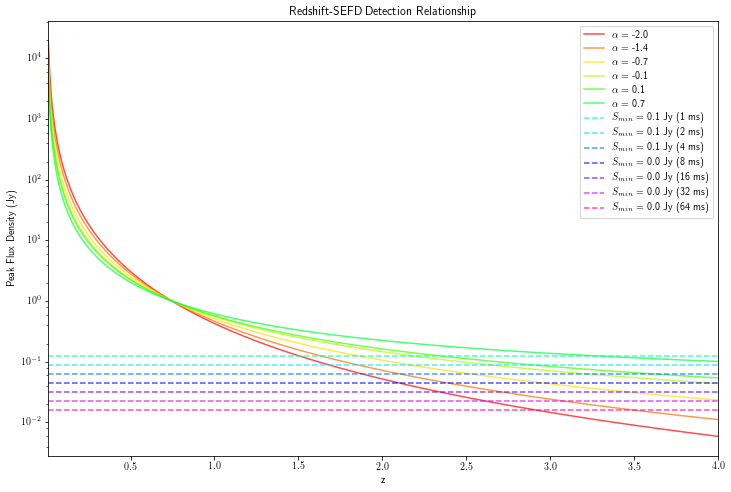

In [281]:
zArr = np.linspace(zMin, zMax, 512)
sPeakArr = np.zeros((len(alphas), len(zArr)))

cmap = plt.cm.hsv
colors = iter(cmap(np.linspace(0, 0.9, len(alphas) + len(sMin))))

for aid, alpha in enumerate(alphas):
    LModel = calcLModel(alphaRef=alpha)
    for zid,zz in enumerate(zArr):
        sPeakArr[aid, zid] = calcSpeak(LModel, zz, alpha, fObsMin, fObsMax)
    plt.semilogy(zArr, sPeakArr[aid], color=next(colors), alpha=0.7, label=r'$\alpha =$ %1.1f'%alpha)

for sMinVal, pwVal in zip(sMin, pulseWidth):
    plt.axhline(y=sMinVal, xmin=0.0, xmax=1.0, color=next(colors), linestyle="--", alpha=0.7, \
                label='$S_{min}=$ %1.1f Jy (%.0f ms)'%(sMinVal, pwVal/1000.))

plt.legend()
plt.xlim(zMin, zMax)
plt.xlabel('z')
plt.ylabel('Peak Flux Density (Jy)')
plt.title('Redshift-SEFD Detection Relationship')

**Figure:** Similar to Figure 6 of Karastergiou et al. 2015, and Figure 2a of Lorimer et al. 2013. Peak flux density of the Lorimer et al. 2013 population model as a function of redshift $z$ and spectral index $\alpha$. Lines of minimum dectection using the ALFABURST system is shown as dashed lines for different decimation levels.

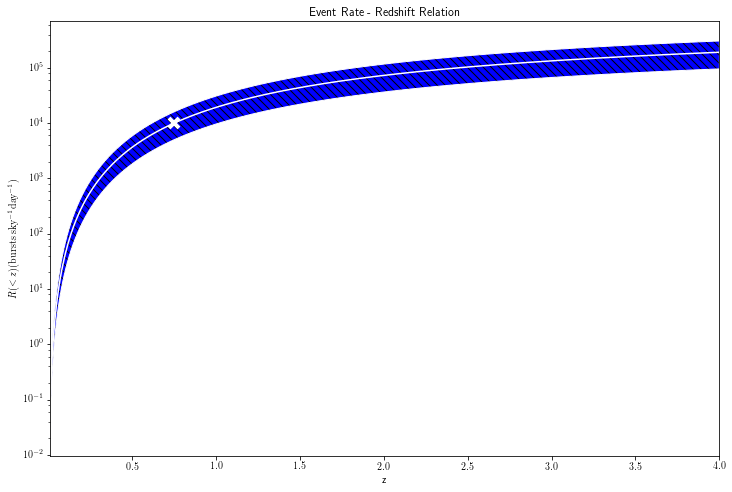

In [282]:
# lorimer 2b, karastergious 6 - rate to redshift relationship
def thorntonRate(z):
    """Compute the event rate using Thornton et al. 2013 values as computed by Lormier et al. 2013
    z: float, redshift
    returns: array, [low rate, expected rate, high rate]"""
    dd = coMovingDist(z)
    dNorm = coMovingDist(0.75) # Thornton rate is based on events at z=0.75
    rateNorm = np.array([0.5 * 10**4, 10**4, 1.6 * 10**4]) # Thornton et al. 2013: rate = 10000 (error: +6000/-5000)
    rate = rateNorm * ((dd / dNorm)**3.)
    return rate

expectedRates = np.zeros((zArr.shape[0], 3))
for zid,zz in enumerate(zArr):
    expectedRates[zid,:] = thorntonRate(zz)

plt.semilogy(zArr, expectedRates[:,1], "w")
plt.fill_between(zArr, expectedRates[:,0], expectedRates[:,2], alpha=1.0, facecolor="blue", edgecolor="white", \
                 hatch="\\\\\\")

plt.plot(0.75, 1e4, "wx", markersize=10, markeredgewidth=4) # plot Thornton et al. (2013) rate

plt.xlim(zMin, zMax)
plt.xlabel('z')
plt.ylabel(r'$R (< z) (\textrm{bursts sky}^{-1} \textrm{day}^{-1})$')

plt.title('Event Rate - Redshift Relation')

**Figure:** Implied redshift to event rate relation based on Thornton et al. 2013 event rate of $10000^{+6000}_{-5000} \; \textrm{bursts sky}^{-1} \textrm{day}^{-1}$ at $z = 0.75$ (white cross).

In [270]:
# Compute rates
# lorimer 2b, karastergious 6 - rate to redshift relationship
# lorimar 2c - peak to rate relationship